# Project Guidance

https://ds.codeup.com/nlp/project/

## Acquisition + Preparation

For this project, you will have to build a dataset yourself. Decide on a list of GitHub repositories to scrape, and use the provided script to acquire the README data for each repository. The repositories you use are up to you, but you should include at least 100 repositories in your data set.
As an example of which repositories to use, here is a link to GitHub's trending repositories, the most forked repositories, and the most starred repositories.

https://github.com/trending

https://github.com/search?o=desc&q=stars:%3E1&s=forks&type=Repositories

https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories

The list of repositories could be generated programatically using web scraping techniques.
Make sure to document where your data comes from. All of the pages linked above change over time, so it would be wise to say something like: "Our data comes from the top 100 trending repositories on GitHub as of $DATE".

## Exploration

Explore and visualize the natural language data that you have acquired. Here are some ideas for exploration:

- What are the most common words in READMEs?

- Does the length of the README vary by programming language?

- Do different programming languages use a different number of unique words?

- Are there any words that uniquely identify a programming language?

## Modeling

- Transform your documents into a form that can be used in a machine learning model. You should use the programming language of the repository as the label to predict.

- Try fitting several different models and using several different representations of the text (e.g. a simple bag of words, then also the TF-IDF values for each).

- Build a function that will take in the text of a README file and try to predict the programming language.

- If you have many different unique values in your target variable, consider narrowing down this list. For example, use the top 3 languages and then label everything else as "Other" so that you have fewer unique values to predict.

# Everything above this will be deleted. This is just for easy reference to the project website assignment

# **Github Programming Language Predictor**
##### **using Natural Language Processing**
<p align ="right">Zacharia Schmitz <br>
October 2023

---


### Rate Limits & Ethics:

Scraping

[**From GitHub Acceptable Use Policies**](https://docs.github.com/en/github/site-policy/github-acceptable-use-policies)

>"Short version: We host a wide variety of collaborative projects from all over the world, and that collaboration only works when our users are able   >to work together in good faith. While using the Service, you must comply with our Acceptable Use Policies, which include some restrictions on content >and conduct on GitHub related to user safety, intellectual property, privacy, authenticity, and other limitations. In short, be excellent to each
>other.

In [1]:
import requests
import pandas as pd
import wrangle as w

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zacschmitz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div style="background-color: #; padding: 0px; ">

## <font size='10'><i>**Plan**</i></font> <font size='5'><i>→ Acquire → Prepare → Explore → Model → Deliver</i></font>

---

### We'll pull 100 README pages from each language and analyze each one individually.

1. Decide Languages

2. Acquire Repos

3. Data Cleaning

4. Text Preprocessing

5. Feature Extraction

6. Model Training

7. Reusable Functionality

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → </i></font> <font size='10'><i>**Acquire**</i></font> <font size='5'><i> → Prepare → Explore → Model → Deliver</i></font>

---

### The `fetch_readmes` function does the following:

<u>Web Scraping</u>

  * Initializes an empty list called `all_readmes` and a set called `processed_repos`.

  * Loops through each language in the `languages` list.

  * Prints a message indicating that it is processing repositories for the current language.

  * Initializes the `page` and `total_processed` variables to the values of `start_page` and 0, respectively.

  * Loops through the pages of the GitHub search results until it has fetched the desired number of README files.

<u>API Usage</u>

  * Calls the `fetch_github_data` function to fetch data from the GitHub API endpoint.

  * Calls the `extract_repo_links` function to extract repository links from the JSON response.

  * Loops through the repository links and calls the `get_readme_content` function to get the content of the README file.

  * If the README content is not `None`, it appends a tuple containing the language, repository URL, and README content to the `all_readmes` list and increments the `total_processed` variable.
  
  * Adds a delay between requests using the `time.sleep` function.
  
  * If the number of repositories to fetch is greater than 10 and the current page is less than or equal to the number of repositories divided by 10, it fetches additional pages of search results.
  
  * Prints a message indicating that it has finished processing repositories for the current language and the total number of README files fetched.
  
  * Converts the `all_readmes` list to a pandas DataFrame and returns it.

### Run this to Check GitHub Rate Limits Before Pulling

In [2]:
# Check current rate limit with GitHub (does not count towards limit)

response = requests.get('https://api.github.com/rate_limit')
response.json()

{'resources': {'core': {'limit': 60,
   'remaining': 60,
   'reset': 1698081916,
   'used': 0,
   'resource': 'core'},
  'graphql': {'limit': 0,
   'remaining': 0,
   'reset': 1698081916,
   'used': 0,
   'resource': 'graphql'},
  'integration_manifest': {'limit': 5000,
   'remaining': 5000,
   'reset': 1698081916,
   'used': 0,
   'resource': 'integration_manifest'},
  'search': {'limit': 10,
   'remaining': 10,
   'reset': 1698078376,
   'used': 0,
   'resource': 'search'}},
 'rate': {'limit': 60,
  'remaining': 60,
  'reset': 1698081916,
  'used': 0,
  'resource': 'core'}}

### Gather Repos

```python

fetch_readmes(languages=["python"], num_repos=5, start_page=1, sleep_time=1, verbose=True)

```

**Parameters:**

- `languages (list)`: A list of programming languages to search for.

- `num_repos (int)`: The number of repositories to fetch README files from.

- `start_page (int)`: The page number to start searching from.

- `sleep_time (int)`: The number of seconds to wait between requests.

- `verbose (bool)`: Whether to print progress messages.

### Takeaways from Scraping/API

- Trying to run all 800 at once, we kept failing for different reasons, so we broke it up, and cached each language as we went.

- With 1 second sleeps on 100 requests, we got a 429 status error (too many requests at 42 fetches)
    - We'll have to either chunk it into less pages, or increase sleeps<br><br>

- With 5 second sleeps, 100 repos took 10 minutes 11 seconds total.

- With 2 second sleeps, it took 5:30 and we did not get rate limited.

- Originally we tried 10 of each language, but the sample size seemed too small.

```python
base_url = "https://github.com/search?q=stars%3A%3E0+language%3A{language}&type=repositories&l={language}&p={page}"

```

```python

# Scrape Javascript
javascript = fetch_readmes(languages=['javascript'], num_repos=100, verbose=True, sleep_time=5)
javascript.to_csv('support_files/javascript_readmes.csv')

# Scrape Python
python = fetch_readmes(languages=['python'], num_repos=100, verbose=True, sleep_time=2)
python.to_csv('support_files/python_readmes.csv')

# Scrape Java
java = fetch_readmes(languages=['java'], num_repos=100, verbose=True, sleep_time=2)
java.to_csv('support_files/java_readmes.csv')

# Scrape HTML
html = fetch_readmes(languages=['html'], num_repos=100, verbose=True)
html.to_csv('support_files/html_readmes.csv')

# Scrape C++
cplus = fetch_readmes(languages=['c++'], num_repos=100, verbose=True)
cplus.to_csv('support_files/cplus_readmes.csv')

# Scrape Ruby
ruby = fetch_readmes(languages=['ruby'], num_repos=100, verbose=True)
ruby.to_csv('support_files/ruby_readmes.csv')

# Scrape Go
go = fetch_readmes(languages=['go'], num_repos=100, verbose=True)
go.to_csv('support_files/go_readmes.csv')

# Scrape TypeScript
typescript = fetch_readmes(languages=['typescript'], num_repos=100, verbose=True)
typescript.to_csv('support_files/typescript_readmes.csv')

```

```python

# Combine them all
df = pd.concat([javascript, python, java, html, cplus, ruby, go, typescript])

# Cache the CSV for future usage
df.to_csv('support_files/read_mes_17oct.csv', index=False)

```

**<u>ALL REPOS PULLED OCTOBER 17th FROM 12:00 to 15:39 (CST)**

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → </i></font> <font size='10'><i>**Prepare**</i></font> <font size='5'><i> → Explore → Model → Deliver</i></font>

--- 

1. Data Cleaning: 
2. Text Preprocessing:

`language`: The target variable indicating the programming language of the repository.
    
- 10 different programming languages (C++, C#, Go, Java, Javascript, PHP, Python, R, Ruby, Swift)

`repo`: The repository's path/name.

- 100 unique repositories for each of the languages above

`readme`: The content of the repository's README.

* `preprocess_text` function takes a text string as input and preprocesses it by performing the following steps:

    * Removes all newline characters using the `re.sub` function.
    
    * Removes all URLs using the `re.sub` function.
    
    * Removes all HTML tags using the `re.sub` function.
    
    * Replaces all hyphens with spaces using the `re.sub` function.
    
    * Removes all punctuation characters using a list comprehension and the `string.punctuation` constant.
    
    * Converts the text to lowercase using the `str.lower` method.
    
    * Removes extra white spaces using the `str.split` and `str.join` methods.
    
    * Loads the list of stopwords using the `stopwords.words` function from the `nltk.corpus` module.
    
    * Adds custom stopwords to the list using the `set.update` method.
    
    * Tokenizes the text using the `word_tokenize` function from the `nltk.tokenize` module.
    
    * Removes all stopwords from the list of tokens using a list comprehension.
    
    * Joins the list of tokens back into a string using the `str.join` method.

Tokenize the text into individual words.

In [3]:
# read in all_readmes.csv
df = pd.read_csv('support_files/read_mes_17oct.csv')

In [4]:
# Apply the preprocessing function to the 'cleaned_readme' column
df['preprocessed_readme'] = df['readme'].apply(w.preprocess_text)

In [5]:
# In exploration, we found some dataframes only had <10 words. We'll limit to dataframes with over 50 words for decent prediction.
df = df[df['preprocessed_readme'].str.split().str.len() > 50]

In [6]:
# Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 0 to 799
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   language             711 non-null    object
 1   repo                 711 non-null    object
 2   readme               711 non-null    object
 3   preprocessed_readme  711 non-null    object
dtypes: object(4)
memory usage: 27.8+ KB


In [7]:
# Show one of each language from the df
df.groupby('language').last()

,repo,readme,preprocessed_readme
language,,,
c++,/SuperHouse/esp-open-rtos,esp-open-rtos\nA community developed open sour...,esp open rtos community developed open source ...
go,/AdguardTeam/dnsproxy,\n\n\n\nDNS Proxy \nA simple DNS proxy server ...,dns proxy simple dns proxy server supports exi...
html,/Azure-Samples/active-directory-dotnet-webapp-...,\n \n \n services\n platforms\n author\n ...,services platforms author active directory dot...
java,/ujwal-coditas/MultiLamp,MultiLamp\nMultiLamp is simple and easy to use...,multilamp multilamp simple easy android librar...
javascript,/mertJF/tailblocks,Tailblocks\nReady-to-use Tailwind CSS blocks\n...,tailblocks ready tailwind css blocks features ...
python,/fergalwalsh/pico,Install\npip install --upgrade pico\nWrite a P...,install pip install upgrade pico write python ...
ruby,/phronos/rails_datatables,"RailsDatatables\nA simpler, Rails-friendly int...",railsdatatables simpler rails friendly interfa...
typescript,/nukeop/nuclear,\n \nDesktop music player focused on streaming...,desktop music player focused streaming free so...


In [ ]:
# Add a check for other symbols


In [8]:
# Check for NA in df
df.isna().sum()

language               0
repo                   0
readme                 0
preprocessed_readme    0
dtype: int64

In [9]:
# How many of each repo
df['language'].value_counts()

language
python        94
javascript    93
go            93
typescript    93
java          92
ruby          91
c++           87
html          68
Name: count, dtype: int64

We're a little short on HTML. We could pull more and add them to get an even distribution if we get more time.

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → Prepare → </i></font> <font size='10'><i>**Explore**</i></font> <font size='5'><i>→ Model → Deliver</i></font>
---

1. Most Common Words in READMEs

2. README Length by Programming Language

3. Number of Unique Words by Programming Language

4. Words Uniquely Identifying a Programming Language

5. Further Exploration

### Most Common Words in READMEs

We'll determine the most frequently occurring words across all READMEs.

* Gets the 5 most common words for the current programming language using the `most_common` method of the `Counter` class and stores the result in the `common_words` dictionary with the current programming language as the key.

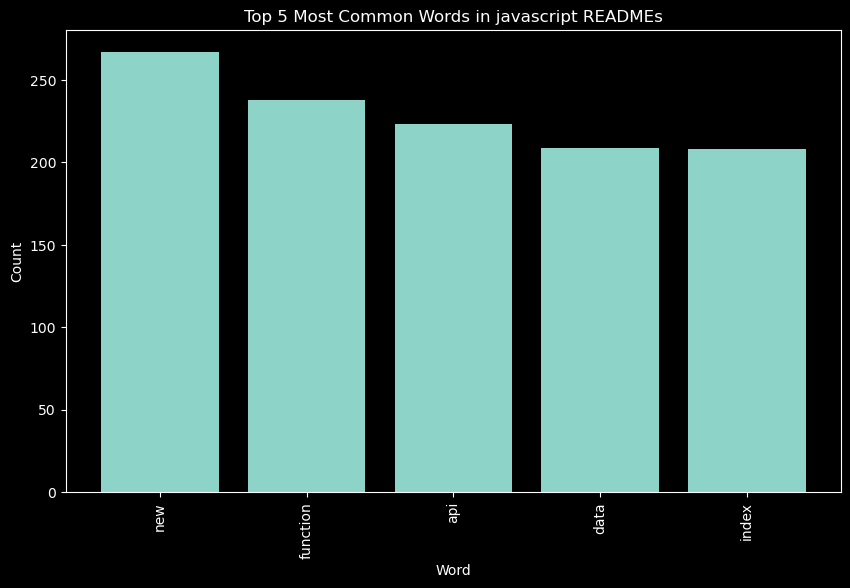

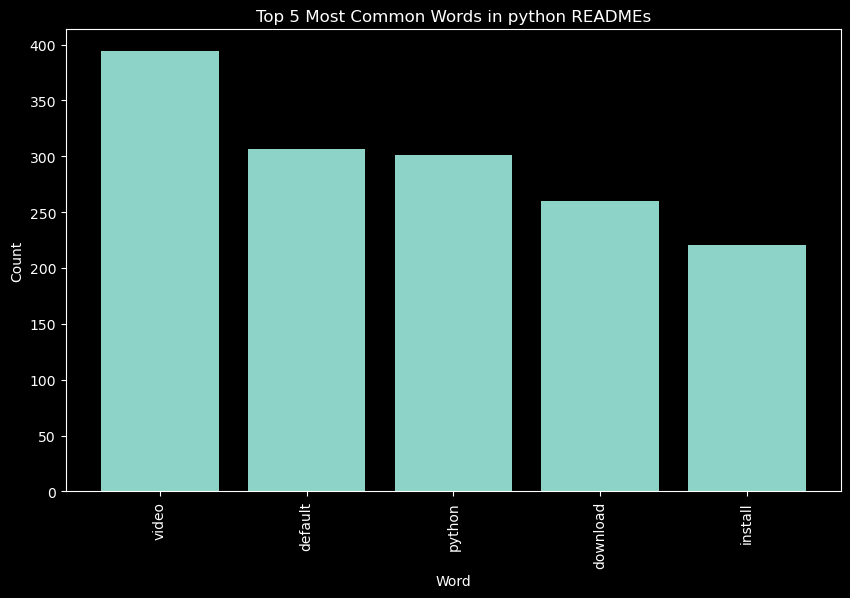

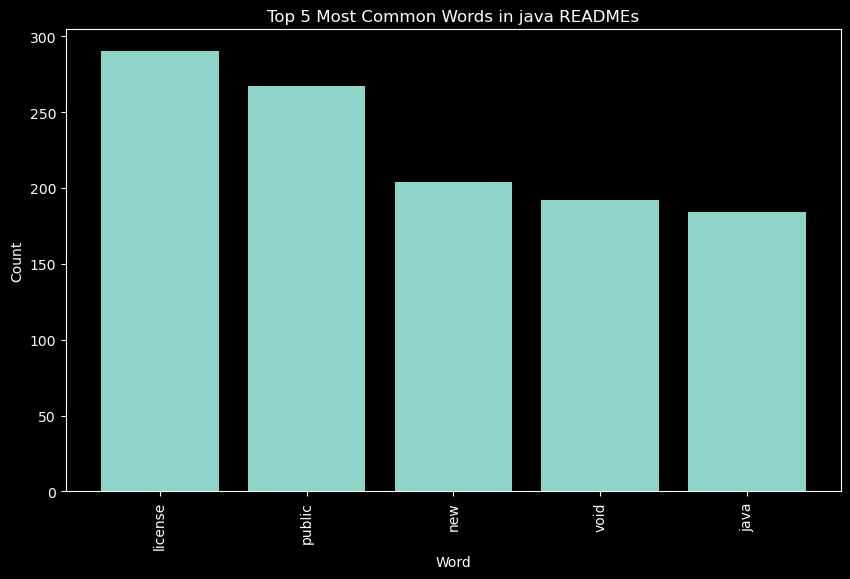

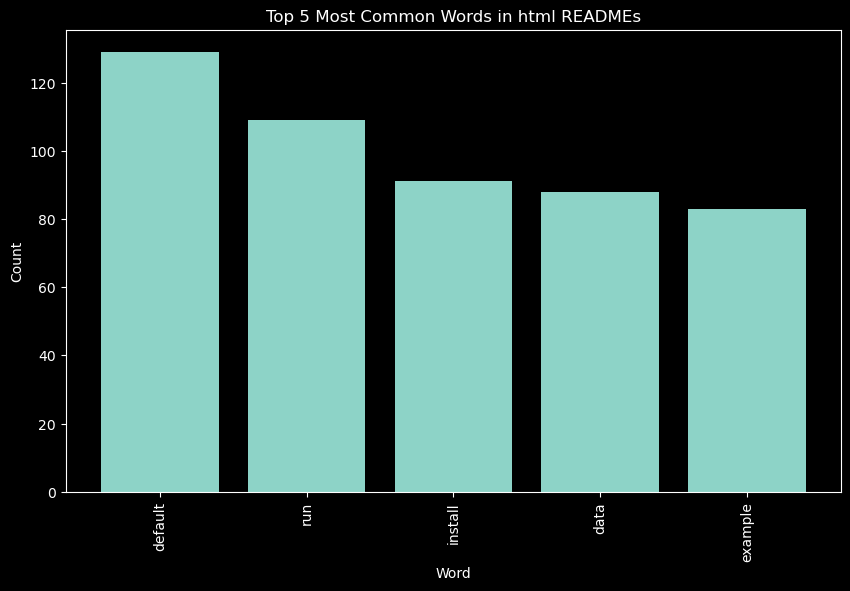

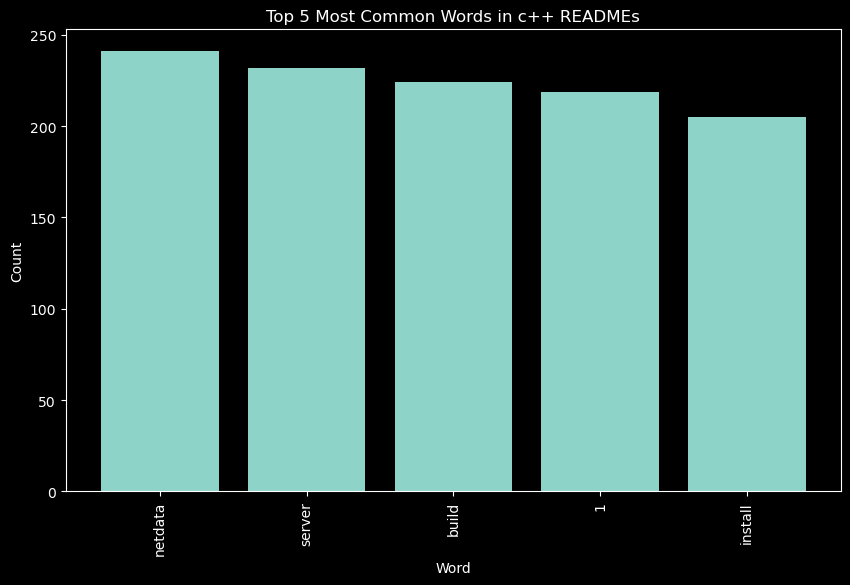

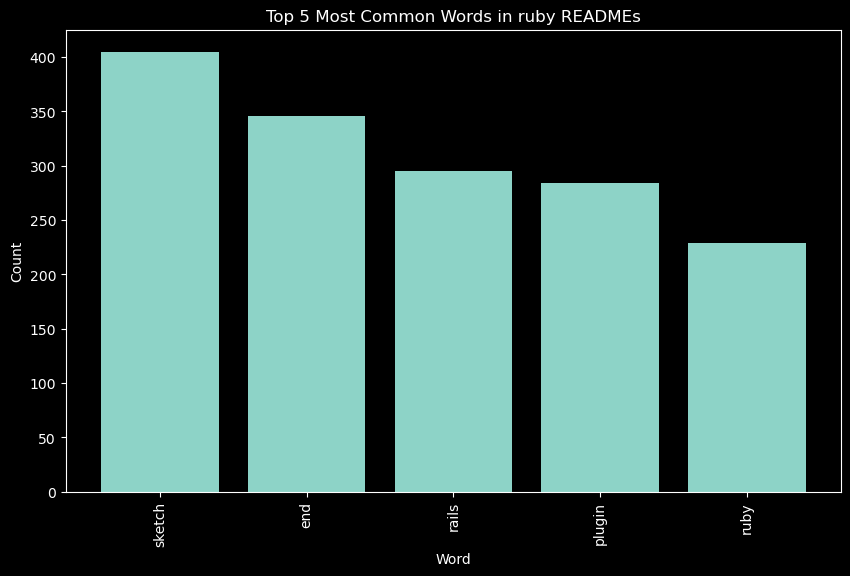

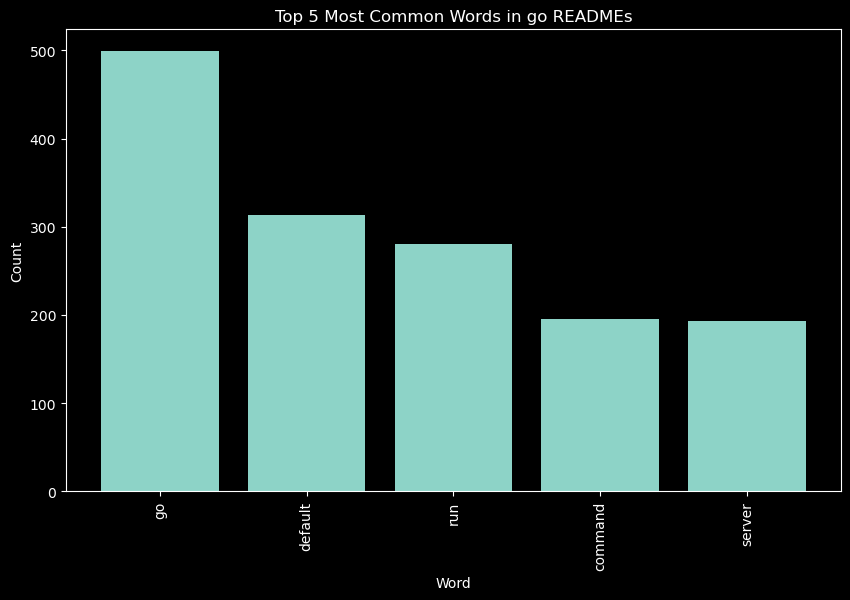

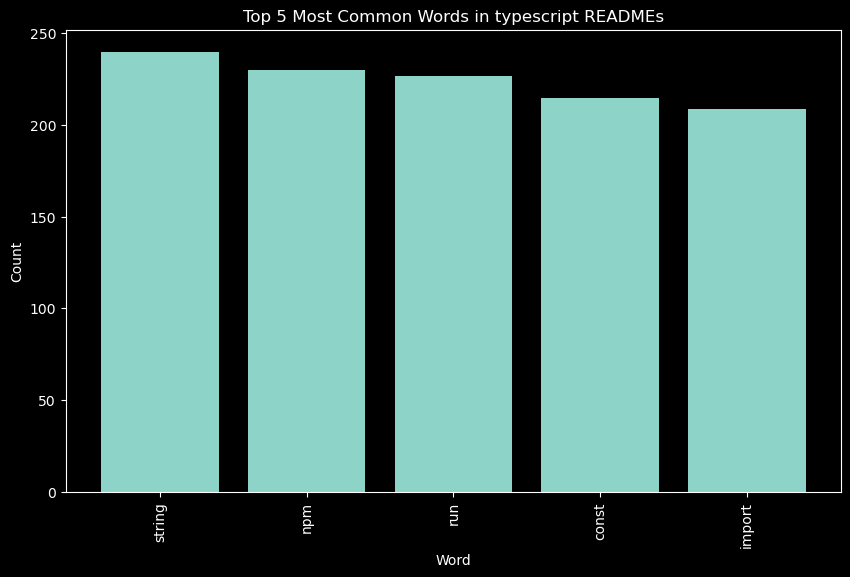

,Language,Word,Count
0,javascript,new,267
0,javascript,function,238
0,javascript,api,223
0,javascript,data,209
0,javascript,index,208
0,python,video,394
0,python,default,307
0,python,python,301
0,python,download,260
0,python,install,221


In [10]:
# Plot 5 most common words for each language in the DF, using the function described above.
w.get_common_words(df, plot=True)

### Word Count Across All Languages

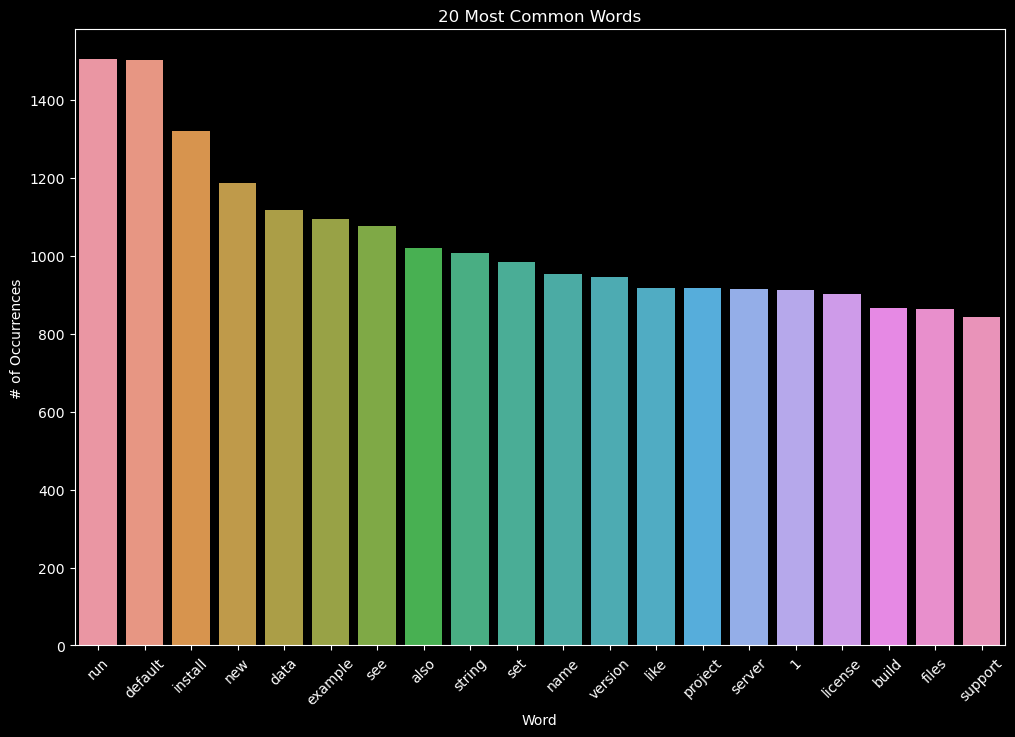

In [11]:
w.plot_top_words(df, num_words=20)

In [12]:
df

,language,repo,readme,preprocessed_readme
0,javascript,/atom/atom,Atom\n\n\nAtom and all repositories under Atom...,atom atom repositories atom archived december ...
1,javascript,/lodash/lodash,lodash\nSite |\nDocs |\nContributing |\nWiki |...,lodash site docs contributing wiki conduct lod...
2,javascript,/cypress-io/cypress,\n \n \n \n \n \n \n...,documentation changelog roadmap web evolved fi...
3,javascript,/iamkun/dayjs,English | 简体中文 | 日本語 | Português Brasileiro | ...,english 简体中文 日本語 português brasileiro 한국어 espa...
4,javascript,/agalwood/Motrix,Motrix\n\n \n \n \n\nA full-featured down...,motrix full featured download manager english ...
...,...,...,...,...
795,typescript,/uNmAnNeR/imaskjs,imaskjs\nvanilla javascript input mask\n\n\n\n...,imaskjs vanilla javascript input mask features...
796,typescript,/Automattic/simplenote-electron,Simplenote for Electron\n\nA Simplenote React ...,simplenote electron simplenote react client pa...
797,typescript,/juliencrn/usehooks-ts,"\n\n\nusehooks-ts\nReact hook library, ready t...",usehooks ts react hook library ready written t...
798,typescript,/benjamine/jsondiffpatch,jsondiffpatch\n\n\n\n\n\n\nDiff & patch JavaSc...,jsondiffpatch diff patch javascript objects li...


#### A look into 'data'

In [13]:
# Plot how many READMEs have the word data in it across all languages

import matplotlib.pyplot as plt
import seaborn as sns

def plot_readme_word_counts(df, word):
    """
    Plots a bar chart of the number of READMEs for each language that contain a given word.

    Args:
        df (pandas.DataFrame): A dataframe containing 'language' and 'readme' columns.
        word (str): The word to search for in the READMEs.

    Returns:
        None
    """
    # Count the number of READMEs for each language that contain the word
    counts = df[df['preprocessed_readme'].str.contains(word, case=False)].groupby('language').size()

    # Plot the counts on a bar chart
    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'Number of READMEs Containing "{word}"')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_readme_word_counts(df, word):
    """
    Plots a bar chart of the number of occurrences of a given word in the preprocessed readme files for each language.

    Args:
        df (pandas.DataFrame): A dataframe containing 'language' and 'preprocessed_readme' columns.
        word (str): The word to search for in the preprocessed readme files.

    Returns:
        None
    """
    # Count the number of occurrences of the word in each preprocessed readme file for each language
    counts = df['preprocessed_readme'].str.count(word).groupby(df['language']).sum()

    # Plot the counts on a bar chart
    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'Number of Occurrences of "{word}" in Preprocessed READMEs')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

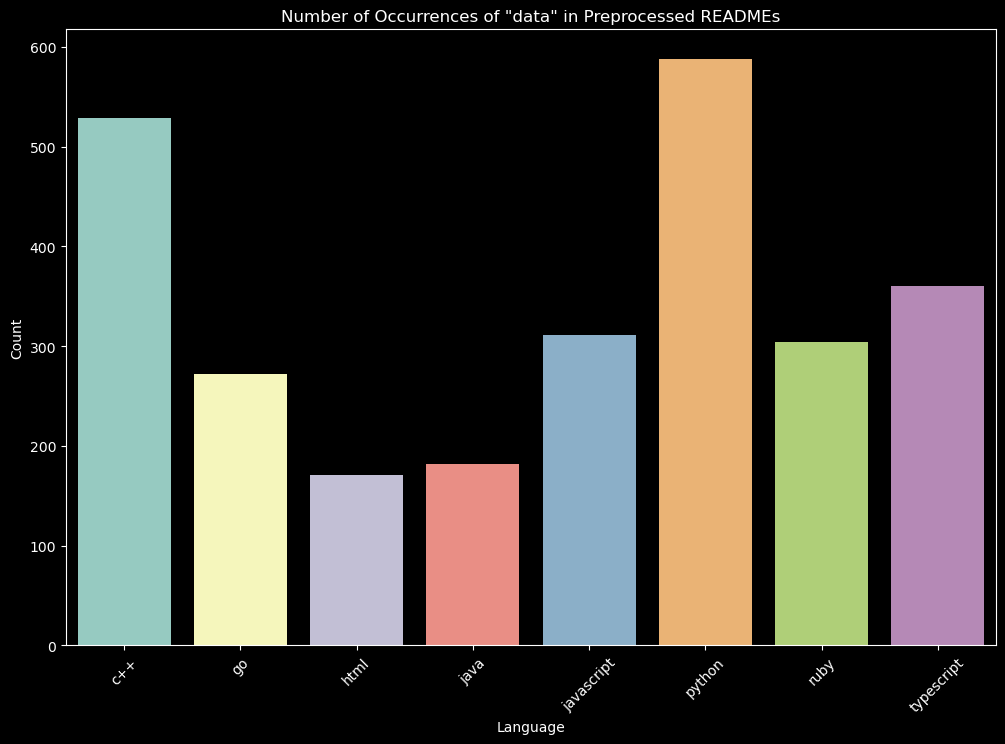

In [15]:
plot_readme_word_counts(df, 'data')

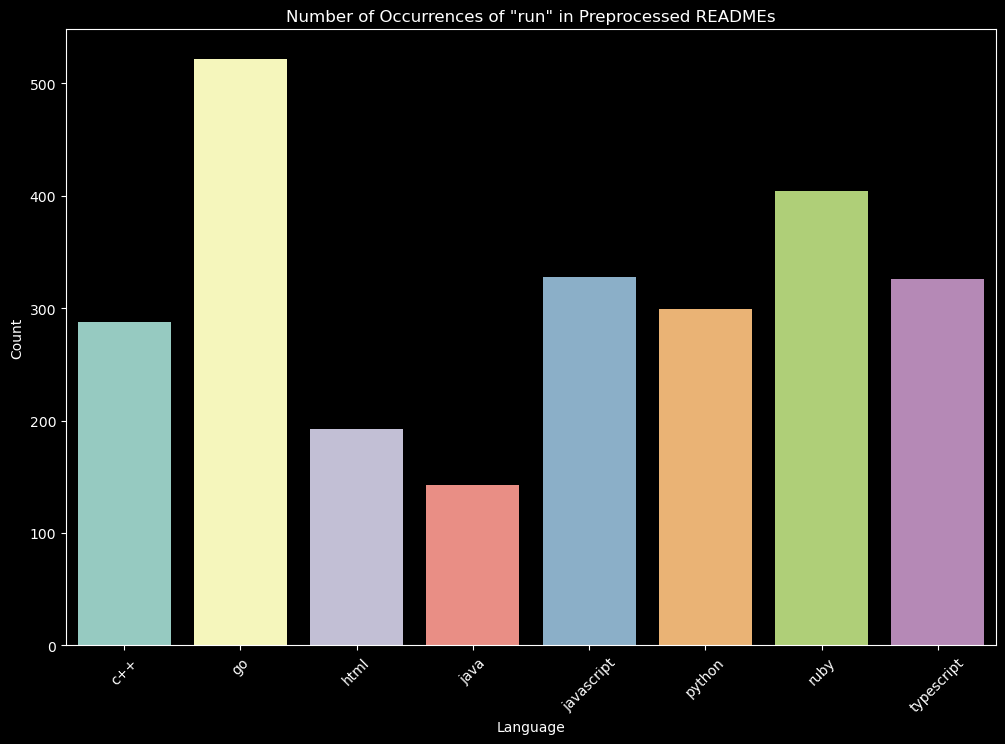

In [16]:
plot_readme_word_counts(df, 'run')

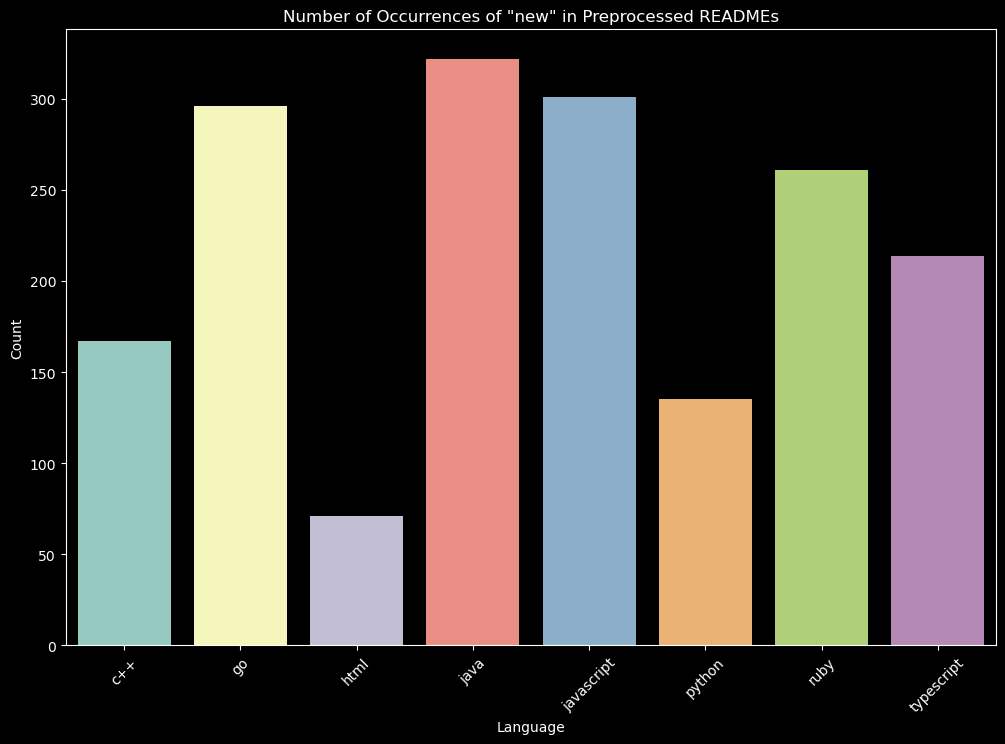

In [17]:
plot_readme_word_counts(df, 'new')

#### Word Cloud

<u>Not intended to provide any analytical value.</u><br>
This is only created for the title slide of the presentation for a surface level visualization.

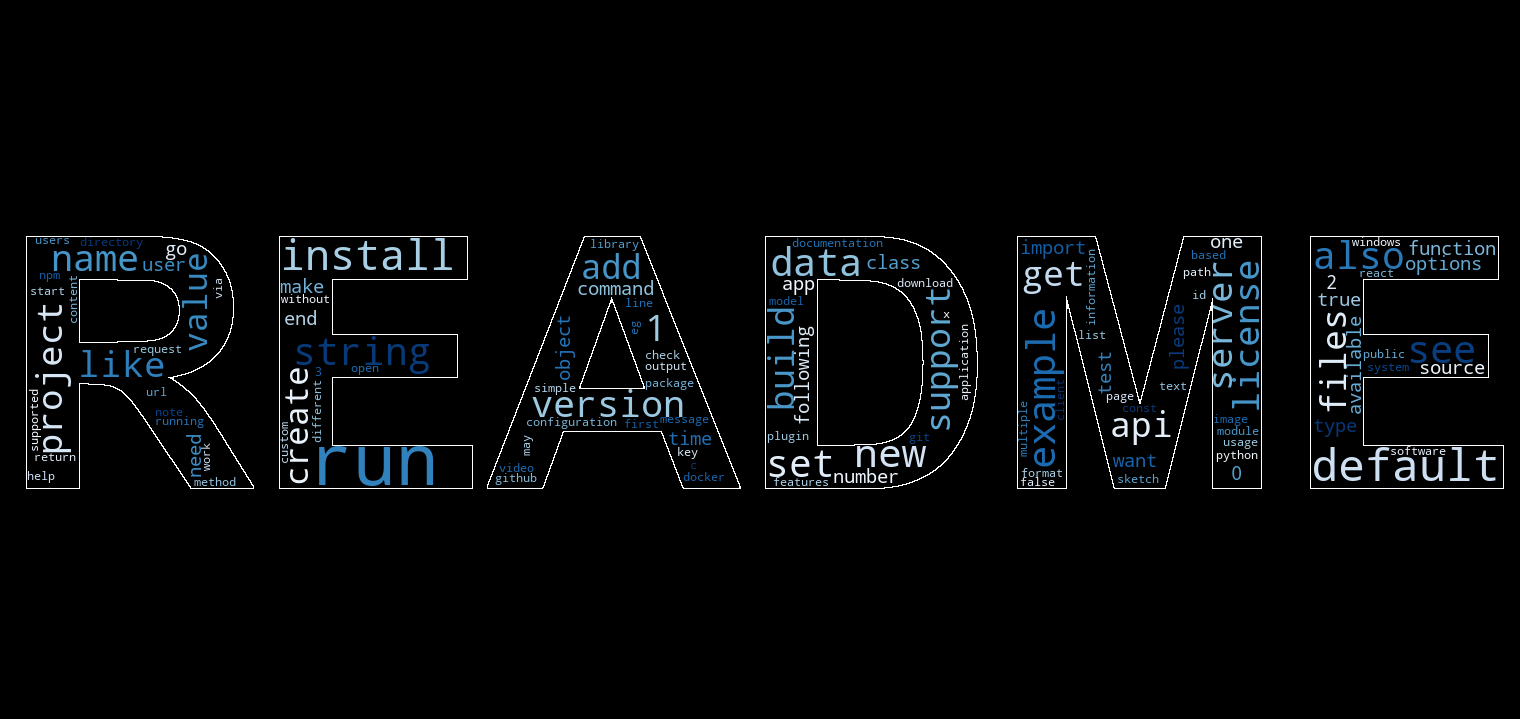

In [18]:
w.generate_wordcloud(df, word_count=300, text='README')

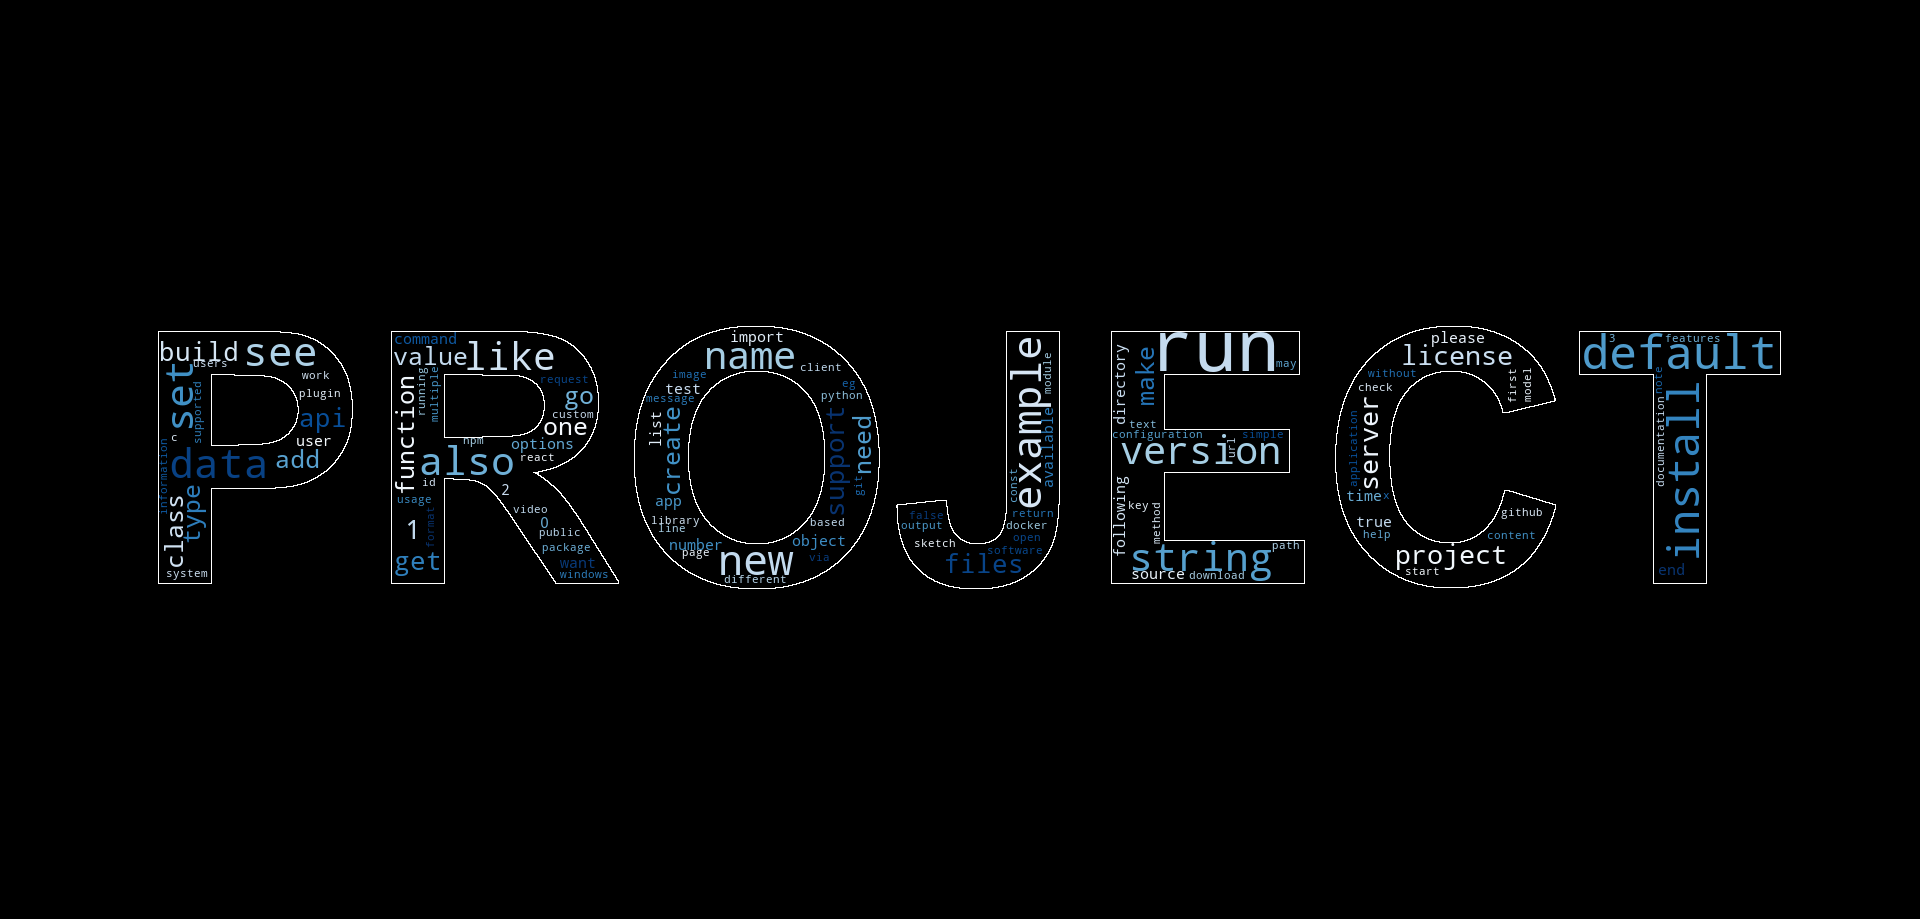

In [19]:
w.generate_wordcloud(df, word_count=300, text='PROJECT', fig_size=(30, 9), width=1900, height=900)

### README Length by Programming Language

We'll visualize the distribution of README lengths for each programming language to determine if there's a noticeable difference.

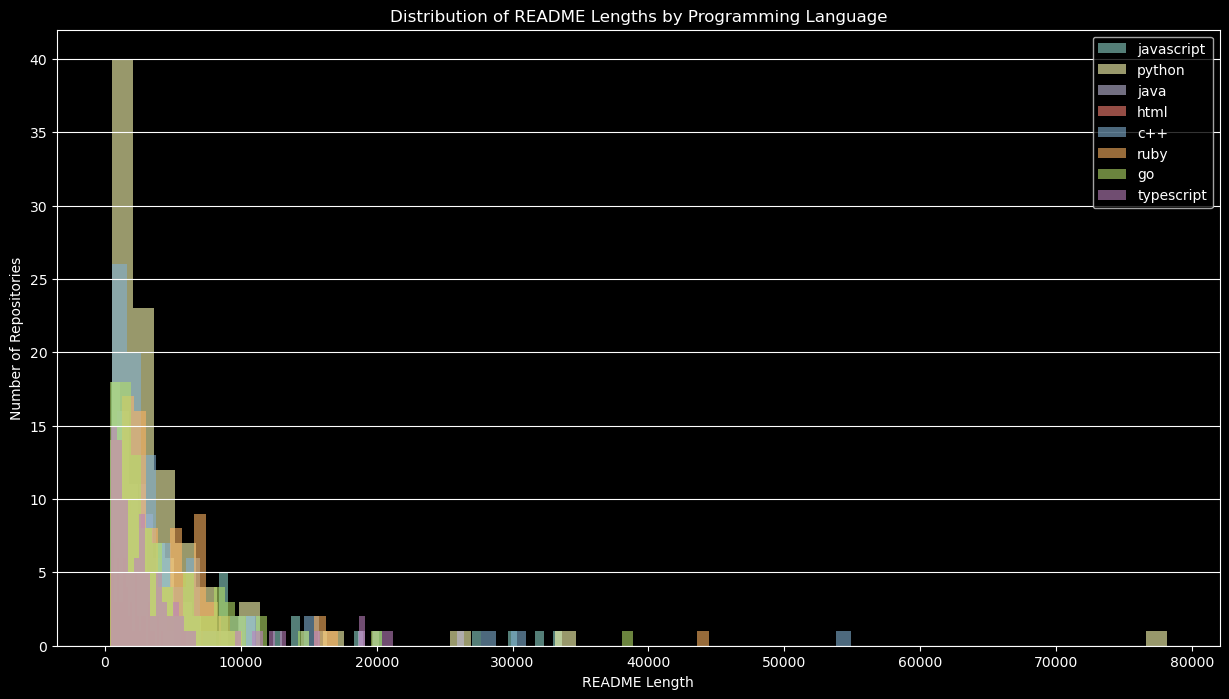

In [20]:
w.plot_readme_length_distribution(df)

              max  min         mean
language                           
c++         54910  496  4648.195402
go          38861  360  4156.258065
html         8561  373  2087.176471
java        26455  386  3354.108696
javascript  33656  409  5028.731183
python      78147  518  4620.340426
ruby        44448  407  4473.538462
typescript  21195  441  3698.258065


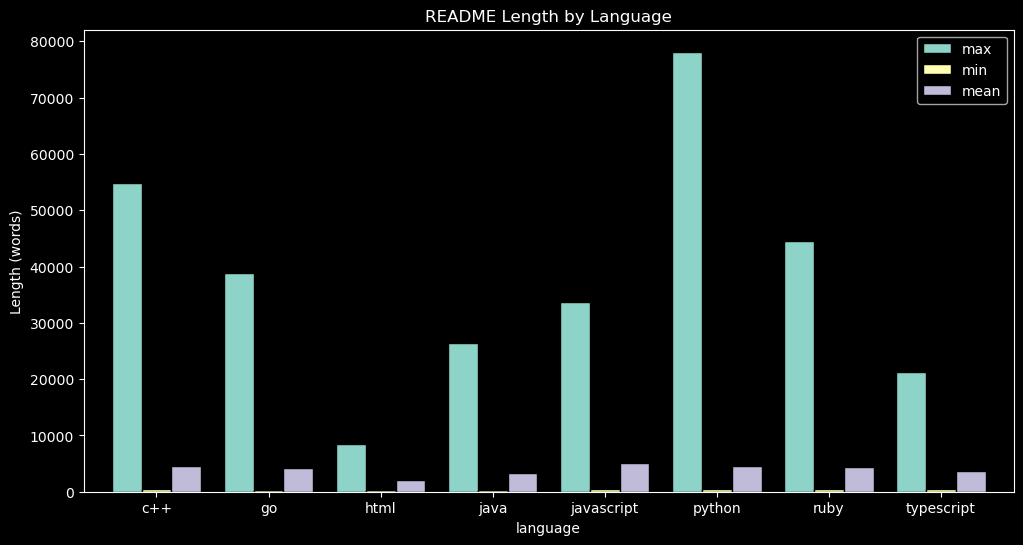

In [21]:
# Calculate the max, min, and mean README lengths by programming language
repos_summary = df.groupby('language')['readme_length'].agg(['max', 'min', 'mean'])

# Print the summary table
print(repos_summary)

# Plot the table
repos_summary.plot.bar(figsize=(12, 6), ec='black', width=.8)
plt.title('README Length by Language')
plt.ylabel('Length (words)')
plt.xticks(rotation=0)
plt.show()


- We cut all repos below 50.

- Python has the longest repo, but seems to be an outlier.

- HTML has a very low max and mean. Seems fairly consistent acrossed repos.

### Number of Unique Words by Programming Language

We'll calculate the number of unique words used in READMEs for each programming language.

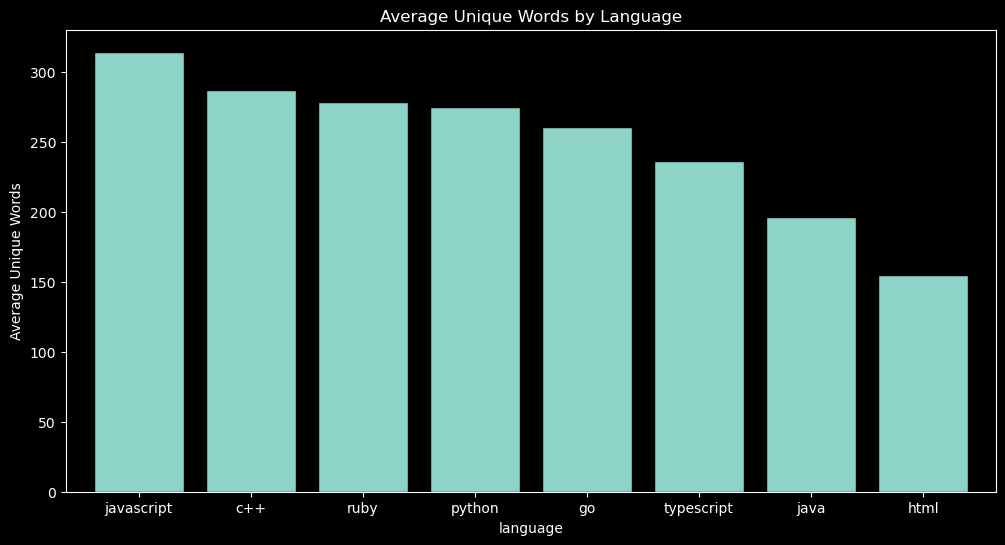

In [22]:
# Calculate the number of unique words for each README
df['unique_word_count'] = df['preprocessed_readme'].apply(lambda x: len(set(x.split())))

# Calculate the average number of unique words by programming language
avg_unique_words_by_language = df.groupby('language')['unique_word_count'].mean().sort_values(ascending=False)

avg_unique_words_by_language

# Plot average unique words
avg_unique_words_by_language.plot.bar(figsize=(12, 6), ec='black', width=.8)
plt.title('Average Unique Words by Language')
plt.ylabel('Average Unique Words')
plt.xticks(rotation=0)
plt.show()

JavaScript repositories tend to have the most diverse vocabulary in their READMEs, with an average of approximately 314 unique words.

C++, Ruby, and Python also have a relatively high number of unique words in their READMEs.

Java and HTML tend to have READMEs with a smaller vocabulary.

### Words Uniquely Identifying a Programming Language

We'll identify words that are highly prevalent in READMEs of one programming language but rare in READMEs of other languages.

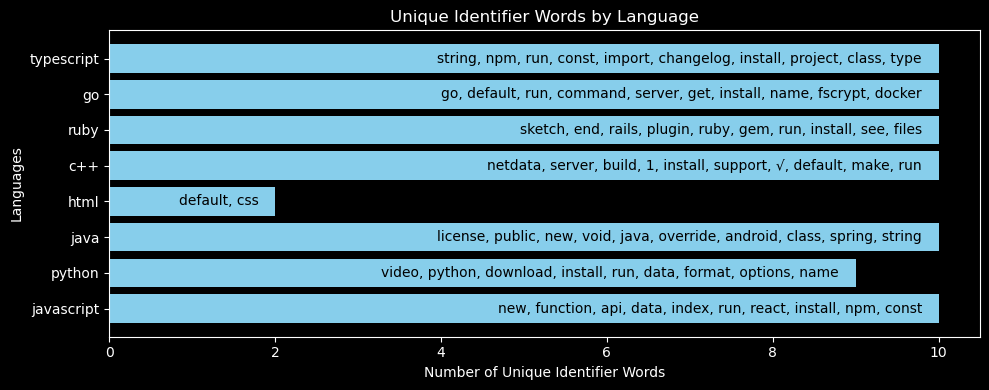

In [23]:
w.plot_unique_identifier_words(df, threshold=0.1, n=10)

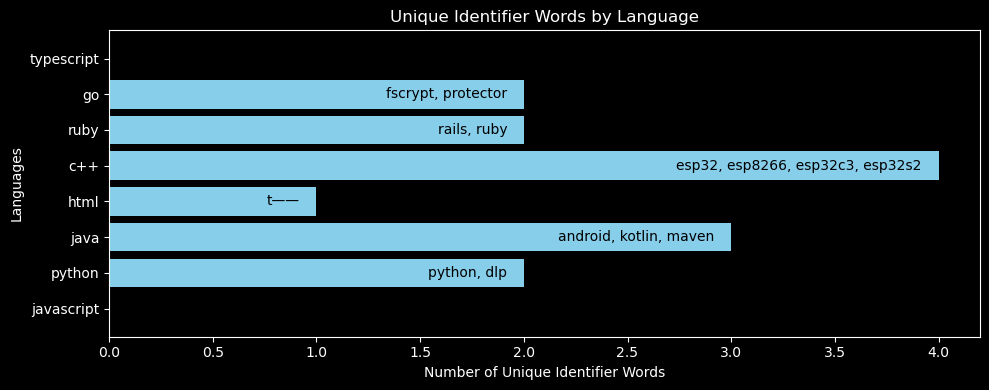

In [24]:
w.plot_unique_identifier_words(df, threshold=0.5, n=50)

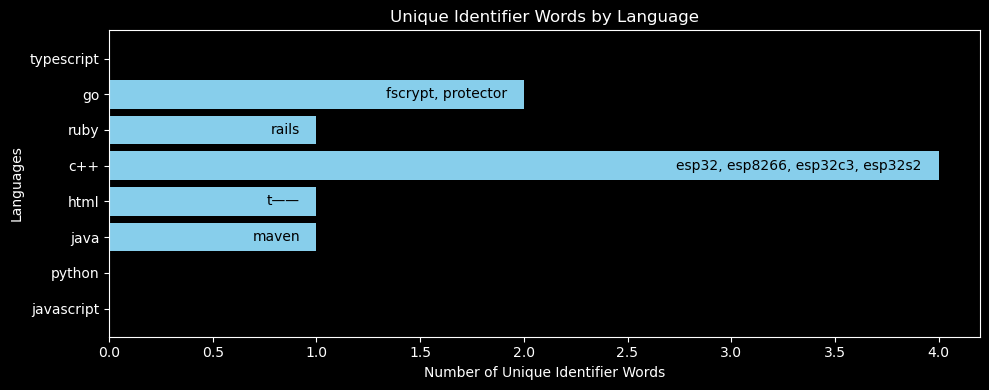

In [25]:
w.plot_unique_identifier_words(df, threshold=0.75, n=50)

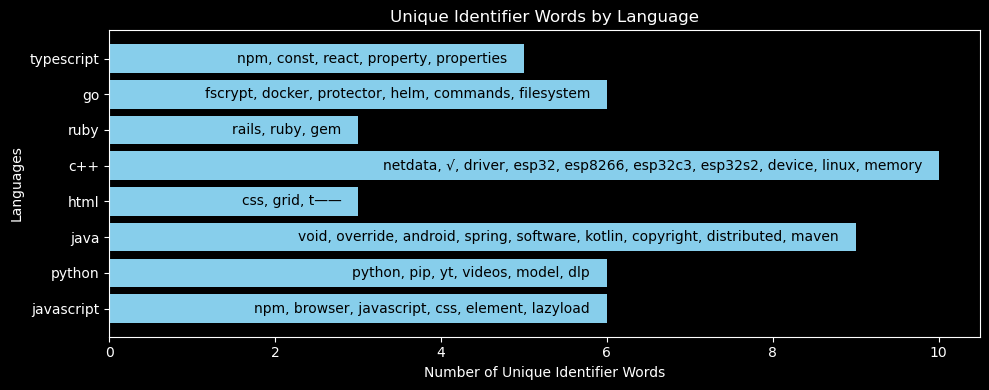

In [26]:
w.plot_unique_identifier_words(df, threshold=0.25, n=50)

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → Prepare → Explore → </i></font> <font size='10'><i>**Model**</i></font> <font size='5'><i>→ Deliver</i></font>
---

# !!!!!!!!!!!!!!!!!!!!!!!!!!!! Word2Vec?

**Representation**:

****`BoW`****: Represents text as raw word counts. For instance, in a document, if the word "apple" appears 5 times, its representation in the **`BoW`** vector would be 5 for that word.

**`TF-IDF`**: Represents text based on the importance of each term relative to the entire corpus. It combines two metrics:
Term Frequency (TF): Measures the frequency of a term in a document (similar to **`BoW`**).
Inverse Document Frequency (IDF): Measures how unique or rare a term is across the entire corpus.

**Weighting**:

**`BoW`**: Gives equal weight to all terms. Common words in a language (like "the", "and", "is") that may appear frequently but offer little value in distinguishing documents will have high values.

**`TF-IDF`**: Weights terms based on their importance in the document relative to the entire corpus. Words that are frequent in a document but not across documents will have high **`TF-IDF`** scores.

**Use Cases**:

**`BoW`**: Given its simplicity, it can be effective for tasks where the sheer occurrence of words is important.

**`TF-IDF`**: Especially useful when you want to understand the importance or significance of words relative to the entire dataset. It can help in tasks like information retrieval, document search, and topic modeling.

**Dimensionality**:

For both **`BoW`** and **`TF-IDF`**, the dimensionality is equal to the size of the vocabulary. However, **`TF-IDF`** usually results in sparser vectors because many term weights will be zero (if the word is not in the document or has zero IDF).

### Term Frequency-Inverse Document Frequency (TF-IDF) 

Useful hyperparameters for `TfidfVectorizer`:

- `max_features`: This hyperparameter controls the maximum number of features (i.e., terms) to include in the TF-IDF matrix. Setting this to a smaller value can help reduce the dimensionality of the matrix and improve performance, especially if the dataset is large.

- `min_df` and `max_df`: These hyperparameters control the minimum and maximum document frequency of terms to include in the TF-IDF matrix. Setting `min_df` to a higher value will exclude terms that appear in fewer than `min_df` documents, while setting `max_df` to a lower value will exclude terms that appear in more than `max_df` documents. These can be useful for removing very rare or very common terms that may not be informative.

- `ngram_range`: This hyperparameter controls the range of n-grams to include in the TF-IDF matrix. An n-gram is a contiguous sequence of n words in a document. Setting `ngram_range` to `(1, 1)` will include only unigrams (i.e., single words), while setting it to `(1, 2)` will include both unigrams and bigrams (i.e., pairs of words).

- `stop_words`: This hyperparameter can be set to a list of stop words to exclude from the TF-IDF matrix. Stop words are common words that are unlikely to be informative, such as "the", "and", and "of".

- `tokenizer`: This hyperparameter can be set to a custom tokenizer function to use instead of the default tokenizer. The tokenizer function should take a string as input and return a list of tokens (i.e., words).

These hyperparameters can be tuned to improve the performance of the TF-IDF vectorization for a specific task or dataset.

In [27]:
# Find the baseline to get a language correct
df.language.value_counts(normalize=True)

language
python        0.132208
javascript    0.130802
go            0.130802
typescript    0.130802
java          0.129395
ruby          0.127989
c++           0.122363
html          0.095640
Name: proportion, dtype: float64

In [28]:
df.shape

(711, 6)

### Baseline: 13%

### The cell below has been converted to raw text so it will not run. 

Convert back to Python in the bottom right to run GridSearch again.

The cell below is the results from the GridSearch

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_readme'], df['language'], test_size=0.2, random_state=321)

# Define the TfidfVectorizer and LogisticRegression objects with the best hyperparameters
tfidf = TfidfVectorizer(max_df=250, max_features=500, min_df=25, ngram_range=(1, 2))
logreg = LogisticRegression(C=1, penalty='l2')

# Initialize the pipeline with the TfidfVectorizer and LogisticRegression objects
pipeline = Pipeline([('tfidf', tfidf), ('logreg', logreg)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict the language labels for the test data
y_pred = pipeline.predict(X_test)

# Calculate the accuracy score for the test data
accuracy = accuracy_score(y_test, y_pred)

# Print the best hyperparameters and accuracy score
print(f"Best parameters: {pipeline.named_steps}")
print(f"Best cross-validation score: {pipeline.score(X_train, y_train)}")

Best parameters: {'tfidf': TfidfVectorizer(max_df=250, max_features=500, min_df=25, ngram_range=(1, 2)), 'logreg': LogisticRegression(C=1)}
Best cross-validation score: 0.8732394366197183


In [30]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=250, max_features=500, min_df=25, ngram_range=(1, 2))
X = tfidf.fit_transform(df['preprocessed_readme'])
y = df['language']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, y_train)

# Calculate the accuracy of the model
print(f"Logistic Regression Train Accuracy: {logit.score(X_train, y_train)}")
print(f"Logistic Regression Test Accuracy: {logit.score(X_test, y_test)}")

Logistic Regression Train Accuracy: 0.8780487804878049
Logistic Regression Test Accuracy: 0.6348314606741573


### Process to Save Our Models for Reapplying

*converted to raw to not export new model files*

## Function(ize) It

## Testing the Functions (With our pulled Repos)

In [31]:
w.predict_language()

Random String: sketch plugin directory list sketch plugins hosted github alphabetical order note want add send pull request use skpm develop skpm takes care publishing automatically plugin added appear website soon make new deploy take anywhere minutes days 10th anniversary ale celebrate sketchs 10th anniversary trip memory lane 6spiral matej marjanovic 6spiral sketch plugin draw spiral shapes archimedean logarithmic spirals also allows convert 2d spirals 3d like helix shapes specified isometric angle add colors palette johnmcclumpha quickly easily add colors fills selected layers sketch file document palette aeux battle axe transfer layer effects android res export ashung hung export android resouces sketch include png assets app icon nine patch image vector drawable angle mengto apply perspective transforms screen mockups auto detect screens resolution works shapes symbols super fast annotations baguette engineering hideshow layer groups named annotations anto canisminor sketch tools

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → Prepare → Explore → Model →</i></font> <font size='10'><i>**Deliver**</i></font>
---

### Takeaways

- Some Repositories Have Multiple Languages

- Read up on scraping/API policy beforehand

- Cache along the way

### Recommendations

#### For Modeling:

- **Feature Engineering:** Consider extracting additional features from the README text, such as the number of code snippets, mentions of specific libraries, and the use of certain punctuations typical to a programming language.

- **Ensemble Methods:** Combine multiple models for better prediction. For instance, a combination of logistic regression, random forests, and gradient boosting might yield improved results.

- **Deep Learning:** Explore deep learning techniques like RNNs or Transformers (e.g., BERT) which can capture sequential information in the text and might improve accuracy.

- **Regularization:** If overfitting is observed, consider employing stronger regularization techniques or using models with built-in regularization like Ridge or Lasso for logistic regression.

- **Class Imbalance:** If certain languages are underrepresented in the dataset, consider techniques like SMOTE, undersampling, or oversampling to address class imbalance.

- **External Data Sources:** Incorporate external data sources or pre-trained embeddings like Word2Vec or FastText to enhance the representation of the README text.

#### For Data Collection:

- **Diversify Sources:** To avoid biases, collect READMEs from various sources, not just popular repositories, to ensure a diverse representation of projects and languages.

- **Update Data Periodically:** Languages and their ecosystems evolve. Ensure the dataset is updated periodically to reflect recent trends and libraries.

### Next Steps:

- **Validation:** Set up a validation framework to periodically test the model on new READMEs and ensure its predictions remain accurate over time.

- **User Feedback:** If this model is deployed as a tool or service, incorporate user feedback mechanisms to continuously improve it.

- **Expand Scope:** Beyond predicting programming languages, consider expanding the project's scope to categorize projects based on their purpose (e.g., web development, data analysis, gaming).

- **Multilabel Classification:** Some projects use multiple languages. Explore models that can predict multiple languages for a single README.

- **Interactive Dashboard:** Develop an interactive dashboard where users can paste README text and get predictions, insights about the prediction confidence, and even see which parts of the text most influenced the prediction.

- **Continuous Learning:** Implement a continuous learning mechanism where the model gets retrained as more data becomes available or if its performance drops below a certain threshold.

- **Topic Modeling:** Beyond just predicting the language, perform topic modeling on READMEs to identify common themes or topics within specific language communities.